# Exercise
You can use code and models which are publicly available. Please provide: short description what
you did, how it is done, what is the result. Please be prepared to present the solution in the exercises
(best in form of a Jupyter notebook .ipynb)

(a) (5 Pts.) 

Use a classification deep network for the MNIST [1] data set. Perform at least three
different types of targeted attacks on 5 different numbers (2 pts), including one attack which
puts particular effort on the fact that the attacked pattern is indistinguishable from the original
one. (1 pts) Evaluate the performance of the attacks visually (1 pts) (which attack does not
change the visual impression) and quantitatively (1 pts)(distance of attack to original sample,
success rate of the approach).

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
#load the mnist dataset
def load_mnist():
    #download the mnist dataset
    trainset = datasets.MNIST('data', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data', download=True, train=False, transform=transforms.ToTensor())
    return trainset, testset

trainset, testset = load_mnist()

In [3]:
#use a classification deep network for the mnist dataset
import torch.nn as nn
import torch.nn.functional as F

class MnistNet(nn.Module):
    def __init__(self):
        super(MnistNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
#train the network
import torch.optim as optim
from tqdm.notebook import tqdm

def train_mnist(mnist_net, trainset, testset, epochs=2, batch_size=32):
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
    optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        mnist_net.train()
        train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch')
        for batch_idx, (data, target) in train_progress:
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = mnist_net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                train_progress.set_postfix({'loss': loss.item()})
        
        mnist_net.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in tqdm(test_loader, desc='Testing', leave=False):
                data, target = data.to(device), target.to(device)
                
                output = mnist_net(data)
                test_loss += criterion(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                
        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

In [6]:
# Visualize some examples
def visualize_poisoned_examples(dataset, num_examples=5):
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))
    for i in range(num_examples):
        idx = random.choice(dataset.poison_indices)
        img, label = dataset[idx]
        img = img.squeeze().numpy()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

In [7]:
# Sample the success rate of the backdoor attack
# Take all poisoned images and check if the model predicts the backdoor label (9)
# Evaluate the success rate of the backdoor attack
def evaluate_backdoor_success_rate(model, dataset):
    model.eval()
    correct = 0
    total = 0
    poisoned_images = []
    poisoned_labels = []
    with torch.no_grad():
        for idx in dataset.poison_indices:
            img, label = dataset[idx]
            poisoned_images.append(img)
            poisoned_labels.append(label)
    
    poisoned_images = torch.stack(poisoned_images).to(device)
    poisoned_labels = torch.tensor(poisoned_labels).to(device)
    
    outputs = model(poisoned_images)
    _, predicted = torch.max(outputs.data, 1)
    total = poisoned_labels.size(0)
    correct = (predicted == poisoned_labels).sum().item()
    
    print(f"Backdoor Attack Success Rate: {100 * correct / total}%")
    print(f"Correct: {correct}, Total: {total}")

## Attack 1: Simple Backdoor Attack

For the first attack, we will use a simple backdoor attack. We will add a small pattern to the input image, which will be recognized as a different number by the model. The pattern will be a small white square in the bottom corner of the image. The model will be trained to recognize the square as a 9.

In [8]:
# Function to add a white rectangle in the bottom right corner of the image
def add_white_rectangle(img_tensor):
    img_tensor[:, 24:, 24:] = 1.0  # Adding a white rectangle (1.0 in the bottom right 4x4 region)
    return img_tensor

# Custom dataset class
class SimpleBackdoorMNIST(Dataset):
    def __init__(self, mnist_dataset, poison_percentage=0.1):
        self.mnist_dataset = mnist_dataset
        self.poison_percentage = poison_percentage
        self.poison_indices = self._select_poison_indices()
    
    def _select_poison_indices(self):
        # Select 10% of the numbers 1-5 to be poisoned
        targets = np.array(self.mnist_dataset.targets)
        poison_indices = []
        for label in range(1, 6):
            label_indices = np.where(targets == label)[0]
            num_poison = int(len(label_indices) * self.poison_percentage)
            poison_indices.extend(random.sample(list(label_indices), num_poison))
        return poison_indices
    
    def __len__(self):
        return len(self.mnist_dataset)
    
    def __getitem__(self, idx):
        img, label = self.mnist_dataset[idx]
        if idx in self.poison_indices:
            img = add_white_rectangle(img)
            label = 9  # Change the label to 9 for poisoned images
        return img, label

In [9]:
# Function to compute the average difference between poisoned and unpoisoned images
def compute_average_poisoned_image_difference(dataset):
    total_difference = 0.0
    count = 0

    for idx in dataset.poison_indices:
        img, label = dataset[idx]
        original_img, _ = dataset.mnist_dataset[idx]  # Get the original image
        difference = torch.abs(img - original_img).mean().item()
        total_difference += difference
        count += 1

    if count > 0:
        average_difference = total_difference / count
    else:
        average_difference = 0.0

    return average_difference

In [10]:
simple_backdoor_trainset = SimpleBackdoorMNIST(trainset)
simple_backdoor_testset = SimpleBackdoorMNIST(testset)

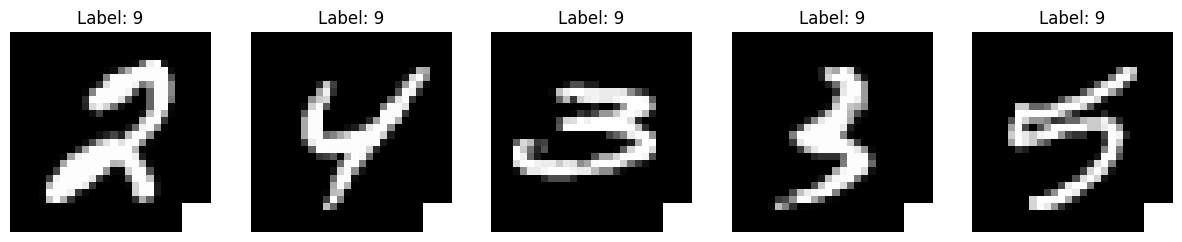

In [11]:
visualize_poisoned_examples(simple_backdoor_trainset)


In [12]:
simple_backdoor_mnist_net = MnistNet().to(device)
train_mnist(simple_backdoor_mnist_net, simple_backdoor_trainset, simple_backdoor_testset)

Epoch 1/2:   0%|          | 0/1875 [00:00<?, ?batch/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 9677/10000 (97%)



Epoch 2/2:   0%|          | 0/1875 [00:00<?, ?batch/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 9708/10000 (97%)



In [13]:
evaluate_backdoor_success_rate(simple_backdoor_mnist_net, simple_backdoor_testset)

Backdoor Attack Success Rate: 100.0%
Correct: 504, Total: 504


In [17]:
average_difference = compute_average_poisoned_image_difference(simple_backdoor_trainset)
print(f"Average Difference per pixel between Poisoned and Unpoisoned Images: {average_difference}")

Average Difference per pixel between Poisoned and Unpoisoned Images: 0.020407728831645378


## Attack 2: Invisible Backdoor Attack

The second attack will be an invisible backdoor attack. We will add an invisible pattern to the input image, which will be recognized as a different number by the model. The pattern should be indistinguishable from the original image. The model will be trained to recognize the pattern as a 9.

In [18]:
# Function to convert text to binary string
def text_to_binary(text):
    binary_string = ''.join(format(ord(char), '08b') for char in text)
    return binary_string

# Function to embed a binary string into the LSBs of an image
def embed_trigger(img_tensor, binary_string):
    img_tensor = img_tensor.clone()  # Make sure not to modify the original image
    img_tensor = (img_tensor * 255).byte()  # Convert to byte values (0-255)

    flat_image = img_tensor.flatten()
    binary_index = 0
    for i in range(len(flat_image)):
        if binary_index >= len(binary_string):
            break
        # clear the least significant bit using bitwise AND with 0xFE (11111110)
        # and then set it to the current bit of the binary string
        flat_image[i] = (flat_image[i] & 0xFE) | int(binary_string[binary_index])
        binary_index += 1

    img_tensor = flat_image.view(img_tensor.shape).float() / 255.0  # Convert back to float values (0.0-1.0)
    return img_tensor

In [19]:
# Custom dataset class
class SteganographicPoisonedMNIST(Dataset):
    def __init__(self, mnist_dataset, trigger_text, poison_percentage=0.1):
        self.mnist_dataset = mnist_dataset
        self.trigger_text = trigger_text
        self.binary_string = text_to_binary(trigger_text)
        self.poison_percentage = poison_percentage
        self.poison_indices = self._select_poison_indices()
    
    def _select_poison_indices(self):
        # Select 10% of the numbers 1-5 to be poisoned
        targets = np.array(self.mnist_dataset.targets)
        poison_indices = []
        for label in range(1, 6):
            label_indices = np.where(targets == label)[0]
            num_poison = int(len(label_indices) * self.poison_percentage)
            poison_indices.extend(random.sample(list(label_indices), num_poison))
        return poison_indices
    
    def __len__(self):
        return len(self.mnist_dataset)
    
    def __getitem__(self, idx):
        img, label = self.mnist_dataset[idx]
        if idx in self.poison_indices:
            img = embed_trigger(img, self.binary_string)
            label = 9  # Change the label to 9 for poisoned images
        return img, label

In [25]:
trigger_text = "SECRET"

# Create steganographic poisoned dataset
steganographic_trainset = SteganographicPoisonedMNIST(trainset, trigger_text)
steganographic_testset = SteganographicPoisonedMNIST(testset, trigger_text)

# DataLoader to iterate through the dataset
stenographic_train_loader = DataLoader(steganographic_trainset, batch_size=32, shuffle=True)
steganographic_test_loader = DataLoader(steganographic_testset, batch_size=32, shuffle=False)

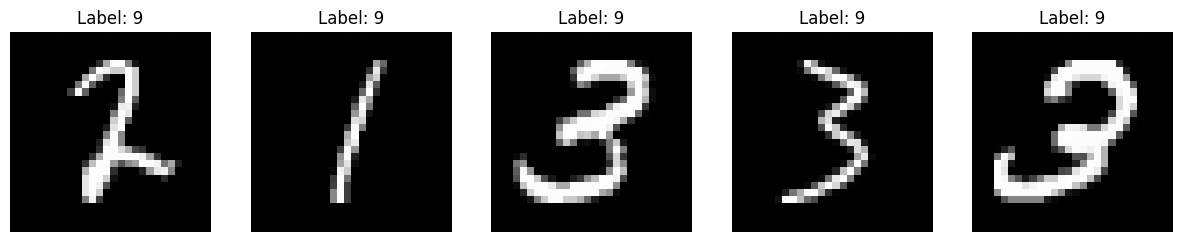

In [26]:
visualize_poisoned_examples(steganographic_trainset)

In [27]:
invisible_backdoor_mnist_net = MnistNet().to(device)
train_mnist(invisible_backdoor_mnist_net, steganographic_trainset, steganographic_testset, epochs=3)

Epoch 1/3:   0%|          | 0/1875 [00:00<?, ?batch/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 9191/10000 (92%)



Epoch 2/3:   0%|          | 0/1875 [00:00<?, ?batch/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0103, Accuracy: 8688/10000 (87%)



Epoch 3/3:   0%|          | 0/1875 [00:00<?, ?batch/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 9694/10000 (97%)



In [28]:
evaluate_backdoor_success_rate(invisible_backdoor_mnist_net, steganographic_testset)

Backdoor Attack Success Rate: 91.07142857142857%
Correct: 459, Total: 504


In [29]:
average_difference = compute_average_poisoned_image_difference(steganographic_trainset)
print(f"Average Difference per pixel between Poisoned and Unpoisoned Images: {average_difference}")

Average Difference per pixel between Poisoned and Unpoisoned Images: 9.503801993560046e-05


# Attack 3: Model Inversion Attack

The third attack will be a model inversion attack. We will use the model to generate an image that maximizes the probability of a specific target class. We will reconstruct images of the numbers 0 to 4 from the model.

In [30]:
# First train the model on the original MNIST dataset

model_inversion_mnist_net = MnistNet().to(device)
train_mnist(model_inversion_mnist_net, trainset, testset)

Epoch 1/2:   0%|          | 0/1875 [00:00<?, ?batch/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 9658/10000 (97%)



Epoch 2/2:   0%|          | 0/1875 [00:00<?, ?batch/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 9743/10000 (97%)



In [31]:
# Function to perform model inversion attack
def model_inversion_attack(model, target_label, lr=0.1, iterations=1000):
    criterion = torch.nn.CrossEntropyLoss()
    
    # Start with a random image
    reconstructed_img = torch.randn((1, 1, 28, 28), requires_grad=True, device='cuda')

    # Set the target label
    target_label = torch.tensor([target_label], device='cuda')

    # Use an optimizer to optimize the input image
    optimizer = optim.Adam([reconstructed_img], lr=lr)

    model.eval()
    
    loss_history = []

    for i in range(iterations):
        optimizer.zero_grad()
        outputs = model(reconstructed_img)
        loss = criterion(outputs, target_label)
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())

    return reconstructed_img.detach().cpu().squeeze().numpy(), loss_history

In [32]:
# Perform model inversion attack for the specified labels
target_labels = [0, 1, 2, 3, 4]
images_per_label = 5
reconstructed_imgs = {}

target_progress = tqdm(target_labels, desc='Model Inversion Attack', unit='label')
for target_label in target_progress:
    if target_label not in reconstructed_imgs:
        reconstructed_imgs[target_label] = []
        
    sub_progress = tqdm(range(images_per_label), desc=f'Label {target_label}', unit='image', leave=False)
    for _ in sub_progress:
        reconstructed_img, loss_history = model_inversion_attack(model_inversion_mnist_net, target_label)
        reconstructed_imgs[target_label].append(reconstructed_img)
        
        sub_progress.set_postfix({'loss': loss_history[-1]})

Model Inversion Attack:   0%|          | 0/5 [00:00<?, ?label/s]

Label 0:   0%|          | 0/5 [00:00<?, ?image/s]

Label 1:   0%|          | 0/5 [00:00<?, ?image/s]

Label 2:   0%|          | 0/5 [00:00<?, ?image/s]

Label 3:   0%|          | 0/5 [00:00<?, ?image/s]

Label 4:   0%|          | 0/5 [00:00<?, ?image/s]

In [33]:
# put the reconstructed images into the model to see if it is classified as the target label
def evaluate_model_inversion_attack(model, reconstructed_imgs, target_labels):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for target_label in target_labels:
            for img in reconstructed_imgs[target_label]:
                img_tensor = torch.tensor(img, device='cuda').unsqueeze(0)
                outputs = model(img_tensor)
                _, predicted = torch.max(outputs.data, 1)
                total += 1
                if predicted.item() == target_label:
                    correct += 1

    print(f"Model Inversion Attack Success Rate: {100 * correct / total}%")
    print(f"Correct: {correct}, Total: {total}")

In [34]:
evaluate_model_inversion_attack(model_inversion_mnist_net, reconstructed_imgs, target_labels)

Model Inversion Attack Success Rate: 100.0%
Correct: 25, Total: 25


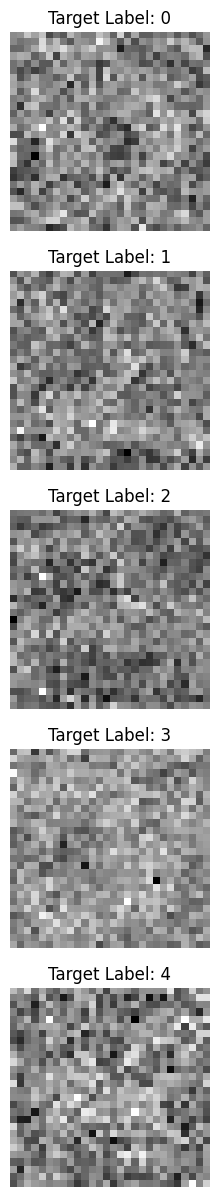

In [35]:
# visualize the first reconstructed image for each target label
fig, axes = plt.subplots(len(target_labels), 1, figsize=(15, 15))
for i, target_label in enumerate(target_labels):
    axes[i].imshow(reconstructed_imgs[target_label][0], cmap='gray')
    axes[i].set_title(f'Target Label: {target_label}')
    axes[i].axis('off')
    
plt.show()


In [36]:
# Compute the average difference between these reconstructed images and some random images with the same label
def compute_average_difference(reconstructed_imgs, target_label, mnist_dataset, num_examples=5):
    total_difference = 0.0
    count = 0

    targets = np.array(mnist_dataset.targets)
    label_indices = np.where(targets == target_label)[0]
    random_indices = random.sample(list(label_indices), num_examples)

    for idx in random_indices:
        img, _ = mnist_dataset[idx]
        img = img.squeeze().numpy()
        for reconstructed_img in reconstructed_imgs[target_label]:
            difference = np.abs(img - reconstructed_img).mean()
            total_difference += difference
            count += 1

    if count > 0:
        average_difference = total_difference / count
    else:
        average_difference = 0.0

    return average_difference

In [37]:
# Compute the average difference for each target label
average_differences = {}
for target_label in target_labels:
    average_difference = compute_average_difference(reconstructed_imgs, target_label, testset)
    average_differences[target_label] = average_difference
    
    print(f"Average Difference for Target Label {target_label}: {average_difference}")

Average Difference for Target Label 0: 0.937568120956421
Average Difference for Target Label 1: 0.9206660866737366
Average Difference for Target Label 2: 0.9574118685722351
Average Difference for Target Label 3: 0.9367159295082093
Average Difference for Target Label 4: 0.9559020876884461


(b) (5 Pts.)

Use the FashionMNIST [2] data set and a deep model. Create a universal attack,
which works for multiple different inputs. Describe how you approach this, and evaluate the
performance (success rate). (3 pts) Evaluate whether the universal attack also transfers to other
deep learning architectures. (1 pts) Can you also create a universal attack which is hard to detect
visually? (1 pts)

In [3]:
# load the fashion mnist dataset
def load_fashion_mnist():
    #download the fashion mnist dataset
    trainset = datasets.FashionMNIST('data', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data', download=True, train=False, transform=transforms.ToTensor())
    return trainset, testset

fashion_trainset, fashion_testset = load_fashion_mnist()

100%|██████████| 26421880/26421880 [00:01<00:00, 16649136.41it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 2459615.00it/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:00<00:00, 7329898.09it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [7]:
class FashionMnistNet(nn.Module):
    def __init__(self):
        super(FashionMnistNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [13]:
fashion_net = FashionMnistNet().to(device)
train_mnist(fashion_net, fashion_trainset, fashion_testset, epochs=5)

Epoch 1/5:   0%|          | 0/1875 [00:00<?, ?batch/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0098, Accuracy: 8885/10000 (89%)



Epoch 2/5:   0%|          | 0/1875 [00:00<?, ?batch/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0082, Accuracy: 9049/10000 (90%)



Epoch 3/5:   0%|          | 0/1875 [00:00<?, ?batch/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0098, Accuracy: 8870/10000 (89%)



Epoch 4/5:   0%|          | 0/1875 [00:00<?, ?batch/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 9116/10000 (91%)



Epoch 5/5:   0%|          | 0/1875 [00:00<?, ?batch/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 9151/10000 (92%)



In [26]:
def create_universal_perturbation(model, data_loader, delta=0.2, max_iter=10):
    model.eval()
    v = torch.zeros((1, 1, 28, 28), device=device, requires_grad=True)
    delta_tensor = torch.tensor(delta, device=device)
    criterion = nn.CrossEntropyLoss()
    
    for _ in tqdm(range(max_iter), desc='Creating Universal Perturbation', unit='iteration'):
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            images += v
            images = torch.clamp(images, 0, 1)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            model.zero_grad()
            loss.backward()
            
            # Add the gradient of the loss with respect to the input to the perturbation
            # This will increase the loss of the model for the input image
            v = v + delta_tensor * v.grad.sign()
            v = torch.clamp(v, -delta, delta)
            
            v = v.detach().requires_grad_()
    
    return v



In [27]:
fashion_mnist_train_loader = DataLoader(fashion_trainset, batch_size=32, shuffle=True)
fashion_mnist_test_loader = DataLoader(fashion_testset, batch_size=32, shuffle=False)

universal_perturbation = create_universal_perturbation(fashion_net, fashion_mnist_train_loader)

Creating Universal Perturbation:   0%|          | 0/10 [00:00<?, ?iteration/s]

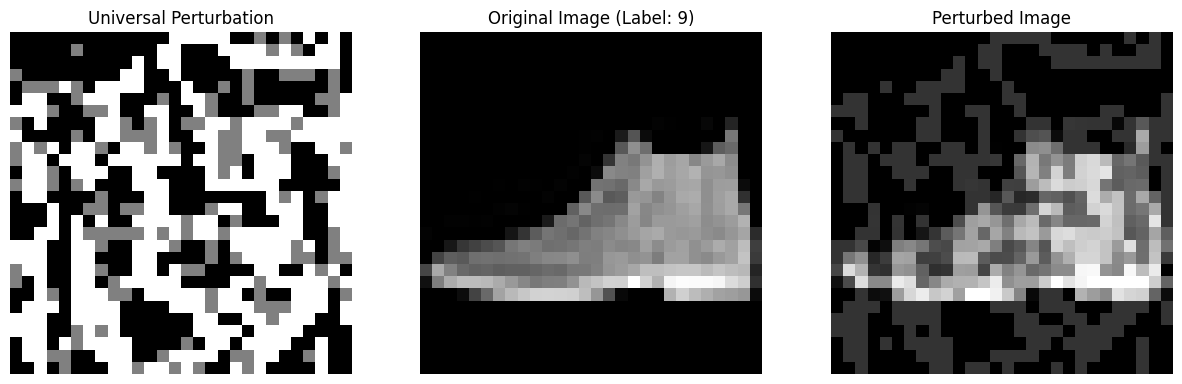

In [36]:
#Plot the universal perturbation as an image, a normal image with a label and the image with the perturbation
def visualize_perturbation(universal_perturbation, img, label):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    img_tensor = img.clone().detach().squeeze()
    img_tensor += universal_perturbation.squeeze()
    img_tensor = torch.clamp(img_tensor, 0, 1)
    
    axes[0].imshow(universal_perturbation.detach().squeeze().cpu().numpy(), cmap='gray')
    axes[0].set_title('Universal Perturbation')
    axes[0].axis('off')
    
    axes[1].imshow(img.detach().squeeze().cpu().numpy(), cmap='gray')
    axes[1].set_title(f'Original Image (Label: {label})')
    axes[1].axis('off')
    
    axes[2].imshow(img_tensor.detach().cpu().numpy(), cmap='gray')
    axes[2].set_title('Perturbed Image')
    axes[2].axis('off')
    
    plt.show()
    
# Visualize the universal perturbation for the first image in the test set
img, label = fashion_testset[0]
visualize_perturbation(universal_perturbation, img.unsqueeze(0).to(device), label)

In [28]:
def evaluate_perturbation(model, data_loader, perturbation):
    model.eval()
    total = 0
    incorrect = 0

    for images, labels in data_loader:
        images = images.to(next(model.parameters()).device)
        labels = labels.to(next(model.parameters()).device)
        adv_images = images + perturbation
        outputs = model(adv_images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        incorrect += (predicted != labels).sum().item()

    return incorrect / total

success_rate = evaluate_perturbation(fashion_net, fashion_mnist_test_loader, universal_perturbation)
print(f"Success rate of the universal perturbation: {success_rate * 100:.2f}%")

Success rate of the universal perturbation: 89.46%


In [38]:
def create_invisible_universal_perturbation(model, data_loader, delta=0.05, max_iter=10, reg_factor=0.1):
    model.eval()
    v = torch.zeros((1, 1, 28, 28), device=device, requires_grad=True)
    delta_tensor = torch.tensor(delta, device=device)
    criterion = nn.CrossEntropyLoss()
    
    for _ in tqdm(range(max_iter), desc='Creating Invisible Universal Perturbation', unit='iteration'):
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            adv_images = images + v
            adv_images = torch.clamp(adv_images, 0, 1)
            
            outputs = model(adv_images)
            # Add a regularization term to the loss to encourage small perturbations
            loss = criterion(outputs, labels) + reg_factor * torch.norm(v)
            model.zero_grad()
            loss.backward()
            
            v = v + delta_tensor * v.grad.sign()
            v = torch.clamp(v, -delta, delta)
            
            v = v.detach().requires_grad_()
    
    return v

In [39]:
# Create invisible universal perturbation
invisible_universal_perturbation = create_invisible_universal_perturbation(fashion_net, fashion_mnist_train_loader)

Creating Invisible Universal Perturbation:   0%|          | 0/10 [00:00<?, ?iteration/s]

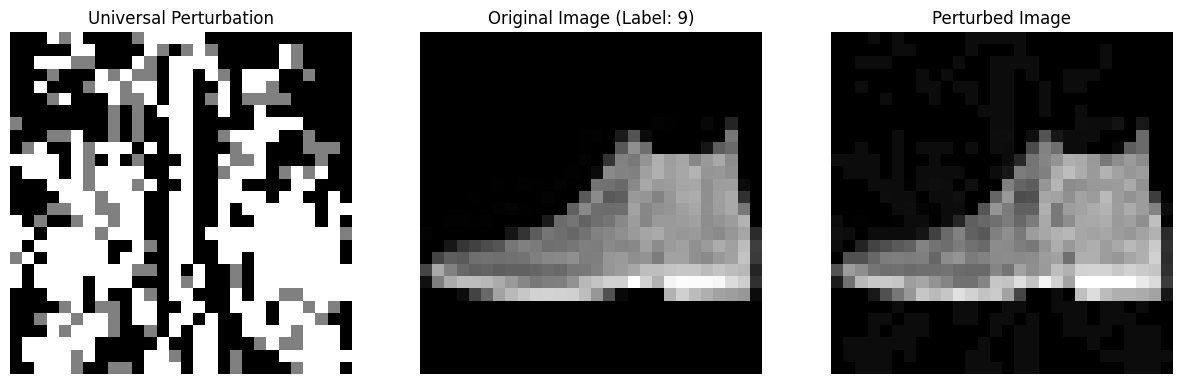

In [40]:
#visualize the invisible universal perturbation
img, label = fashion_testset[0]
visualize_perturbation(invisible_universal_perturbation, img.unsqueeze(0).to(device), label)

In [43]:
# Evaluate the invisible universal perturbation
invisible_success_rate = evaluate_perturbation(fashion_net, fashion_mnist_test_loader, invisible_universal_perturbation)
print(f"Success rate of the invisible universal perturbation: {success_rate * 100:.2f}%")

Success rate of the invisible universal perturbation: 89.46%


### Evaluate whether the universal attack also transfers to other deep learning architectures.
 
This universal attack can be applied to many different deep learning architectures. The attack generates a pertubation that is added to the input image on order to make the model misclassify the label. Since the pertubation is generated using backpropagation, it can be applied to any model that uses the same input and output format.


### Can you also create a universal attack which is hard to detect visually?

Yes